<div style="background-color:#000;"><img src="pqn.png"></img></div>

## Library installation
Install the required Python packages so this notebook can fetch data, compute statistics, and plot results anywhere you run it. This ensures a clean, reproducible setup for the VaR workflow.

In [ ]:
!pip install yfinance pandas numpy matplotlib scipy

yfinance pulls prices, pandas and numpy handle the tabular math, scipy provides the normal quantile, and matplotlib draws the chart. Running this cell once per environment avoids import errors later. If you are in a locked environment, confirm these are preinstalled and skip the install.

## Imports and setup
We import pandas for DataFrame operations, numpy for vectorized linear algebra, scipy.stats.norm for the normal quantile, matplotlib.pyplot for plotting, and yfinance to download prices.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import yfinance as yf

This small stack is enough to replicate a desk-style daily VaR check without heavy infrastructure. Keeping versions stable helps avoid small numerical drift across runs. In production, it’s good practice to pin versions and log them alongside your daily risk output.

## Define portfolio and fetch prices
Set the portfolio composition, capital base, and tail probability, then download daily closes with yfinance over a fixed window. This establishes what risk we measure and provides the price history needed for returns.

In [4]:
tickers = ["AAPL", "META", "C", "DIS"]
weights = np.array([0.25, 0.3, 0.15, 0.3])
portfolio_value = 1_000
confidence = 0.05

In [5]:
data = yf.download(
    tickers, start="2018-01-01", end="2021-12-31"
)["Close"]

/var/folders/6m/0ykpdmvn3lb5qkq15hk3s11c0000gn/T/ipykernel_22291/2418303877.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  4 of 4 completed


Weights should sum to one, capital sets the dollar scale, and alpha=0.05 targets the left 5% tail for a 95% one-sided check. Always confirm symbols and data quality; FB is now META and adjusted closes are preferable when accounting for splits and dividends. In a daily workflow, pull a recent window and rerun this block each morning before sizing positions.

## Compute returns and estimate moments
Convert prices to daily percentage returns, estimate each asset’s mean and the covariance matrix, and combine them with weights to get portfolio drift and volatility. Express both in fraction and dollar terms to prepare for a dollar VaR.

In [6]:
returns = data.pct_change()
mean_returns = returns.mean()
port_mean = mean_returns.dot(weights)
investment_mean = (1 + port_mean) * portfolio_value
cov_matrix = returns.cov()
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
investment_stdev = portfolio_value * port_stdev

The covariance captures co-movement, which is the key upgrade over eyeballing single names. A recent rolling window (about 30–60 trading days for equities) keeps this estimate current; long samples can stale your risk. Drift is small day to day, so many teams ignore it for speed, but we include it so you can see the full parametric form.

## Calculate VaR and scale horizon
Map the left tail of the normal distribution to a dollar loss using norm.ppf with alpha, the mean, and the dollar volatility. Convert that threshold into a one-day VaR and extend it across multiple days under the square-root-of-time rule.

In [7]:
percent_point = norm.ppf(confidence, investment_mean, investment_stdev)
value_at_risk = portfolio_value - percent_point
print(f"Portfolio VaR: {value_at_risk}")

Portfolio VaR: 28.257793003030656


In [8]:
value_at_risks = value_at_risk * np.sqrt(range(1, 31))

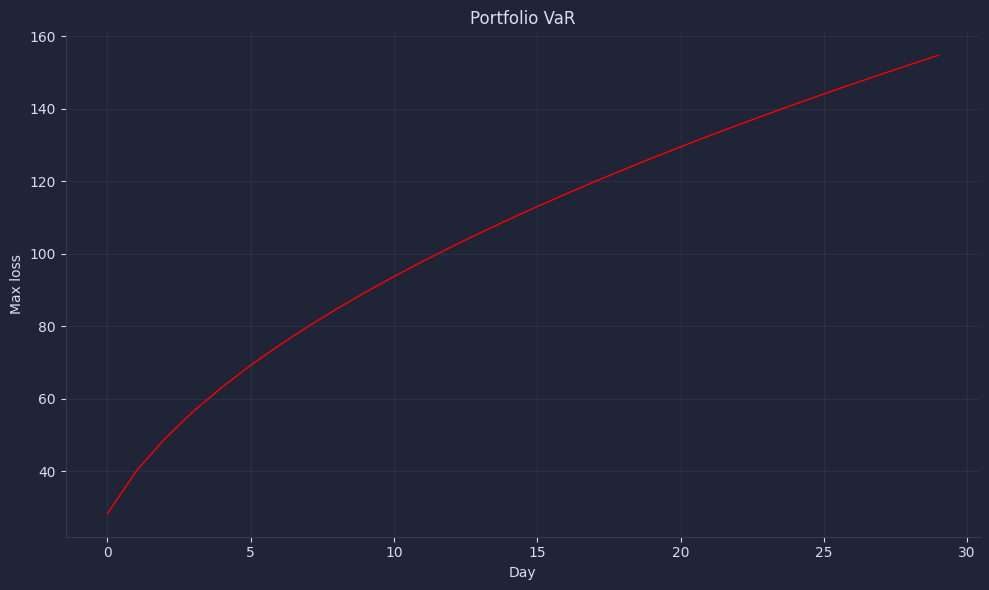

In [9]:
plt.xlabel("Day")
plt.ylabel("Max loss")
plt.title("Portfolio VaR")
plt.plot(value_at_risks, "r")

With small drift, the 95% parametric VaR is roughly 1.645 times dollar volatility, which is a good mental check against the printed value. Scaling assumes independent daily returns and stable volatility; crises, gaps, and fat tails can break this, so also inspect 99% and add simple shocks. The curve gives a concrete loss budget you can use to cap size and leverage per strategy.

<a href="https://pyquantnews.com/">PyQuant News</a> is where finance practitioners level up with Python for quant finance, algorithmic trading, and market data analysis. Looking to get started? Check out the fastest growing, top-selling course to <a href="https://gettingstartedwithpythonforquantfinance.com/">get started with Python for quant finance</a>. For educational purposes. Not investment advice. Use at your own risk.